<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Laboratorio_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219
Intersemestral 2020

# Integrantes

*   Juan José Villegas
*   Juan Sebastián Méndez

## Taller
## Segundo Problema

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.


# 0. Importar librerias

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Descarga de los datos

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 2. Perfilamiento y entendimiento de los datos

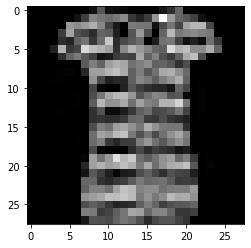

In [15]:
# select any random index from 1 to 60,000
i = random.randint(1,60000)
plt.imshow(X_train[i] , cmap = 'gray')

In [16]:
label = y_train[i]
label

6

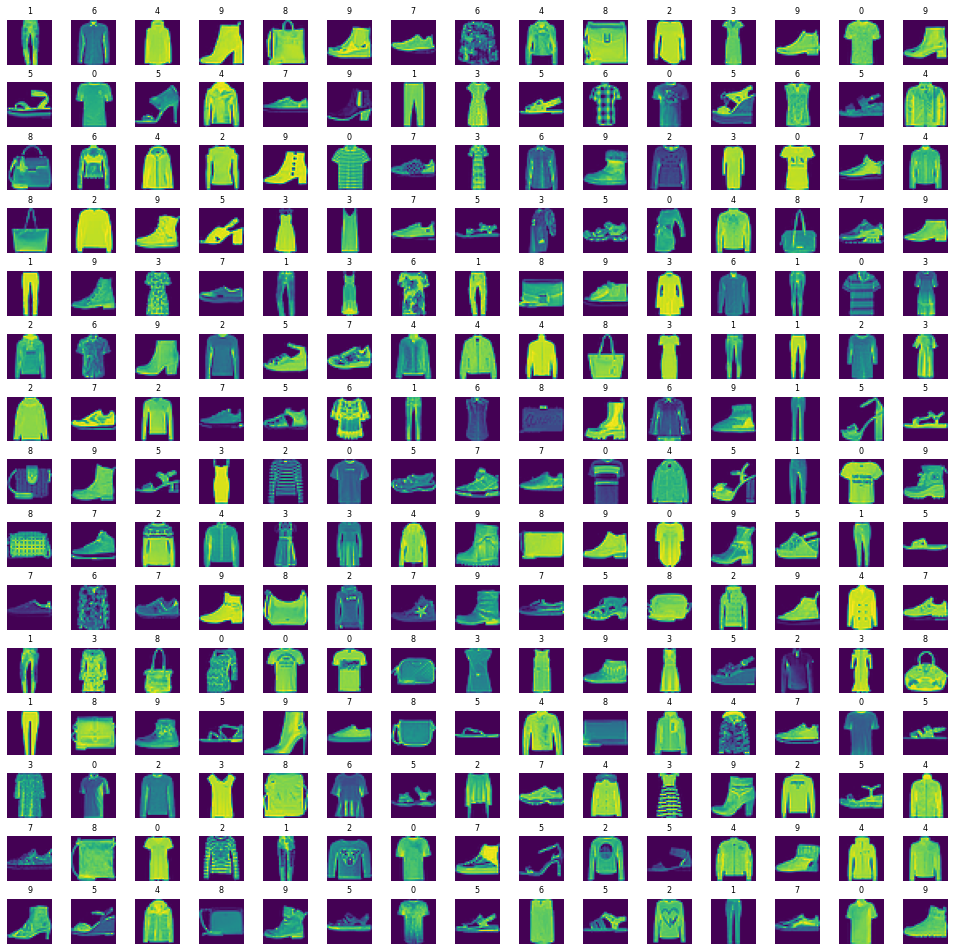

In [19]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

# 3. Preparación de datos

In [20]:
X_train = X_train / 255
X_test = X_test / 255

In [24]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Se agrega ruido a los datos:

In [21]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [22]:
X_train_noise = noising_image(X_train, 0.2)
X_test_noise = noising_image(X_test, 0.2)

In [23]:
print(X_train_noise.shape)
print(X_test_noise.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualizamos como es el resultado de agregar ruido a una de las imagenes:

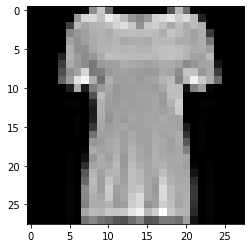

In [25]:
plt.imshow(X_train[10], cmap="gray")

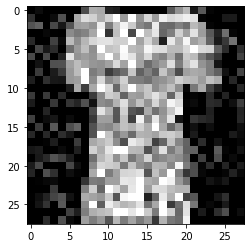

In [26]:
plt.imshow(X_train_noise[10], cmap="gray")

# 3. Modelamiento

## 3.1. Entrenamiento de un perceptrón multicapa.

## 3.2. Entrenamiento de un undercompleted autoencoder

## 3.3. Entrenamiento de un denoising autoendoder